# Preparation

Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import BinaryEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, r2_score

Read Data

In [2]:
df = pd.read_csv('../data/data_saudi_used_cars.csv')

Check Raw Data

In [3]:
def classify_feature(col):
    if pd.api.types.is_numeric_dtype(df[col]):
        return 'Numerical'
    else:
        return 'Categorical'

data_info = pd.DataFrame({
        'Feature': df.columns,
        'Data Type': df.dtypes,
        'Feature Type': [classify_feature(col) for col in df.columns],
        'Null': df.isna().sum(),
        'Min': [f"{df[col].min():,}" if pd.api.types.is_numeric_dtype(df[col]) else '-' for col in df.columns],
        'Max': [f"{df[col].max():,}" if pd.api.types.is_numeric_dtype(df[col]) else '-' for col in df.columns],
        'Mode': [df[col].mode()[0] if not df[col].mode().empty else None for col in df.columns],
        'nUnique': [df[col].nunique() for col in (df.columns)],
        'Unique Value List': [', '.join(map(str, sorted(df[col].unique()))) for col in df.columns] 
    })
data_info.sort_values(by='Data Type')
data_info.reset_index(drop=True, inplace=True)
print(f'Jumlah baris: {df.shape[0]:,}, Jumlah kolom: {df.shape[1]:,}')
print('-' * 80)
display(data_info)

Jumlah baris: 5,624, Jumlah kolom: 11
--------------------------------------------------------------------------------


,Feature,Data Type,Feature Type,Null,Min,Max,Mode,nUnique,Unique Value List
0,Type,object,Categorical,0,-,-,Land Cruiser,347,"2, 3, 300, 3008, 301, 360, 4Runner, 5, 500, 50..."
1,Region,object,Categorical,0,-,-,Riyadh,27,"Abha, Al-Ahsa, Al-Baha, Al-Jouf, Al-Medina, Al..."
2,Make,object,Categorical,0,-,-,Toyota,58,"Aston Martin, Audi, BMW, BYD, Bentley, Cadilla..."
3,Gear_Type,object,Categorical,0,-,-,Automatic,2,"Automatic, Manual"
4,Origin,object,Categorical,0,-,-,Saudi,4,"Gulf Arabic, Other, Saudi, Unknown"
5,Options,object,Categorical,0,-,-,Full,3,"Full, Semi Full, Standard"
6,Year,int64,Numerical,0,"1,963","2,022",2016,50,"1963, 1964, 1965, 1975, 1977, 1978, 1979, 1980..."
7,Engine_Size,float64,Numerical,0,1.0,9.0,3.5,71,"1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1..."
8,Mileage,int64,Numerical,0,100,"20,000,000",300000,1716,"100, 104, 105, 106, 107, 108, 109, 110, 111, 1..."
9,Negotiable,bool,Numerical,0,0,1,False,2,"False, True"


check Duplicate

In [4]:
df.duplicated().sum()

4

Analisa Data Numerical

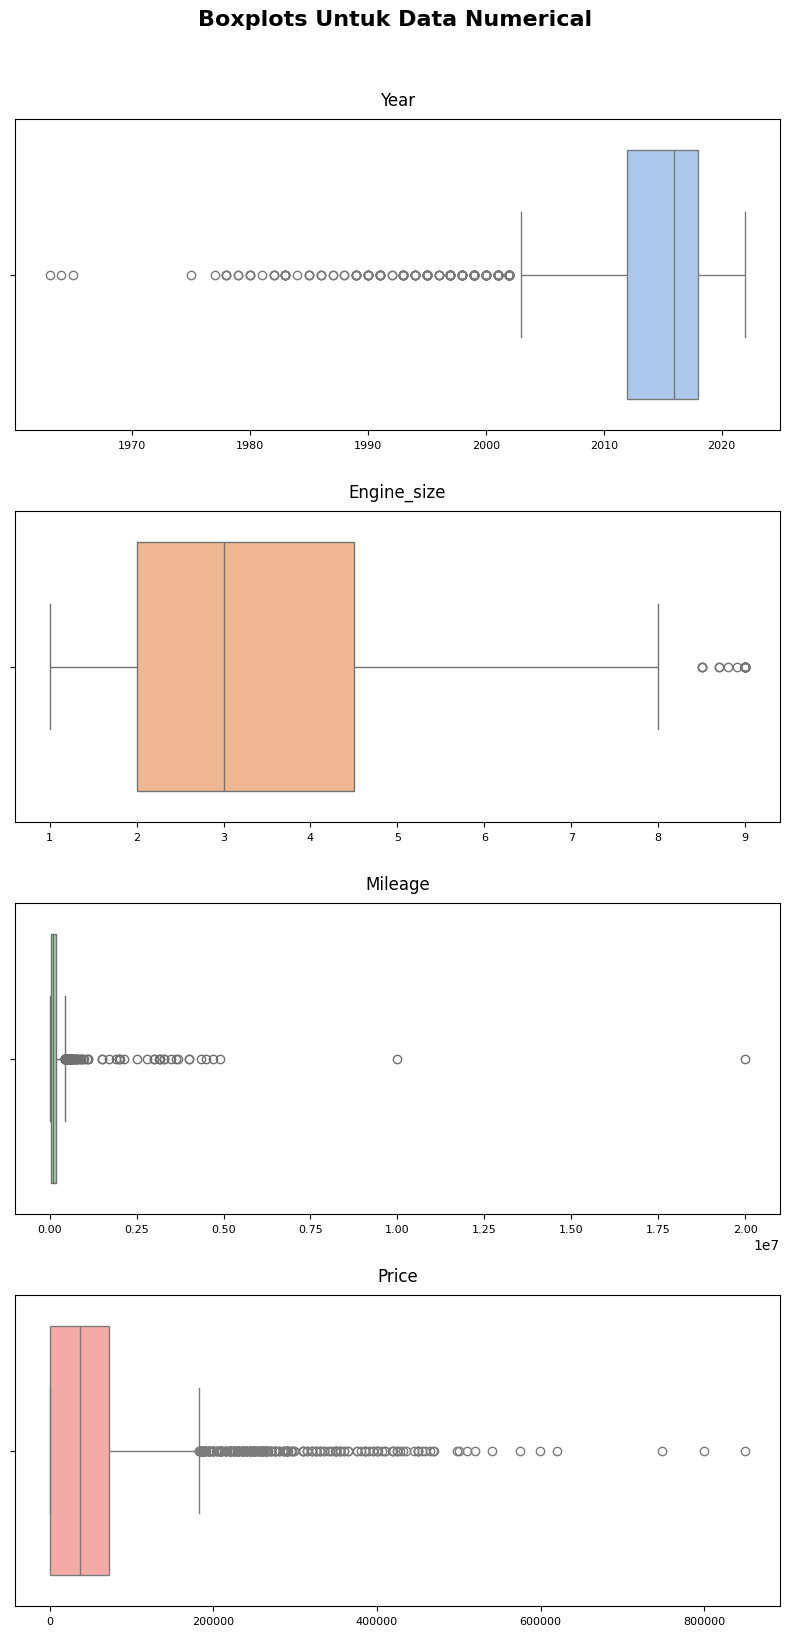

In [5]:
# Pilih kolom numerik
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Tentukan jumlah subplot berdasarkan jumlah kolom numerik
fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(8, len(numeric_columns) * 4))

# Pilih warna untuk plot
colors = sns.color_palette("pastel", len(numeric_columns))

# Loop untuk membuat box plot untuk setiap kolom numerik
for i, column in enumerate(numeric_columns):
    sns.boxplot(data=df, x=column, ax=axes[i], color=colors[i])
    axes[i].set_title(column.capitalize(), fontsize=12, pad=10)
    axes[i].set_xlabel('') 
    axes[i].set_ylabel('')  
    axes[i].tick_params(axis='both', labelsize=8)

# Setel judul keseluruhan untuk plot
plt.suptitle('Boxplots Untuk Data Numerical', fontsize=16, fontweight='bold', y=1.02)

# Sesuaikan layout agar tidak overlap
plt.tight_layout()

# Tampilkan plot
plt.show()


Mileage : terdapat outlier yang sangat jauh dari lain akan dibuang
-> hanya ginakan Mileage yang kurang dari 5e6

Cleaning Data
- Drop Duplicate Data
- Mileage < 5,000,000
- Remove Price 0 dan 1 (setelah d cek ada nilai 1)
- Create kolom baru Age = Current Year - year
- Drop Kolom Year dan Negotiable

In [6]:
def cleaning_data(df):
    df = df.drop_duplicates()
    df = df[df['Mileage'] < 5_000_000]
    df = df[df['Price'] > 1]
    current_year = 2024
    df['Age'] = current_year - df['Year']
    df = df.drop(columns=['Year', 'Negotiable'])
    
    return df

In [7]:
cleaned_df = cleaning_data(df)

Cleaned Data yang akan menjadi Input Model

In [8]:
def classify_feature(col):
    if pd.api.types.is_numeric_dtype(cleaned_df[col]):
        return 'Numerical'
    else:
        return 'Categorical'

data_info = pd.DataFrame({
        'Feature': cleaned_df.columns,
        'Data Type': cleaned_df.dtypes,
        'Feature Type': [classify_feature(col) for col in cleaned_df.columns],
        'Null': cleaned_df.isna().sum(),
        'Min': [f"{cleaned_df[col].min():,}" if pd.api.types.is_numeric_dtype(cleaned_df[col]) else '-' for col in cleaned_df.columns],
        'Max': [f"{cleaned_df[col].max():,}" if pd.api.types.is_numeric_dtype(cleaned_df[col]) else '-' for col in cleaned_df.columns],
        'Mode': [cleaned_df[col].mode()[0] if not cleaned_df[col].mode().empty else None for col in cleaned_df.columns],
        'nUnique': [cleaned_df[col].nunique() for col in (cleaned_df.columns)],
        'Unique Value List': [', '.join(map(str, sorted(cleaned_df[col].unique()))) for col in cleaned_df.columns] 
    })
data_info.sort_values(by='Data Type')
data_info.reset_index(drop=True, inplace=True)
print(f'Jumlah baris: {cleaned_df.shape[0]:,}, Jumlah kolom: {cleaned_df.shape[1]:,}')
print('-' * 80)
display(data_info)

Jumlah baris: 3,822, Jumlah kolom: 10
--------------------------------------------------------------------------------


,Feature,Data Type,Feature Type,Null,Min,Max,Mode,nUnique,Unique Value List
0,Type,object,Categorical,0,-,-,Camry,320,"2, 3, 300, 3008, 301, 360, 4Runner, 5, 500, 50..."
1,Region,object,Categorical,0,-,-,Riyadh,27,"Abha, Al-Ahsa, Al-Baha, Al-Jouf, Al-Medina, Al..."
2,Make,object,Categorical,0,-,-,Toyota,56,"Aston Martin, Audi, BMW, BYD, Bentley, Cadilla..."
3,Gear_Type,object,Categorical,0,-,-,Automatic,2,"Automatic, Manual"
4,Origin,object,Categorical,0,-,-,Saudi,4,"Gulf Arabic, Other, Saudi, Unknown"
5,Options,object,Categorical,0,-,-,Full,3,"Full, Semi Full, Standard"
6,Engine_Size,float64,Numerical,0,1.0,9.0,3.5,65,"1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1..."
7,Mileage,int64,Numerical,0,100,"4,500,000",300000,1345,"100, 105, 107, 108, 109, 110, 111, 113, 114, 1..."
8,Price,int64,Numerical,0,500,"850,000",55000,465,"500, 850, 884, 950, 988, 993, 1000, 1002, 1010..."
9,Age,int64,Numerical,0,3,61,8,41,"3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1..."


PREPROCESSING

In [9]:
X = cleaned_df.drop(columns=['Price'])
y = cleaned_df['Price']

Data Spitting (80:20)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Transformasi Data

In [11]:
transformer = ColumnTransformer([
    ('One-Hot', OneHotEncoder(drop='first'), ['Options', 'Origin', 'Gear_Type']),
    ('Binary', BinaryEncoder(), ['Type', 'Region', 'Make']),
    ('Robust', RobustScaler(),['Age','Engine_Size', 'Mileage'])
], remainder='passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('One-Hot', OneHotEncoder(drop='first'),
                                 ['Options', 'Origin', 'Gear_Type']),
                                ('Binary', BinaryEncoder(),
                                 ['Type', 'Region', 'Make']),
                                ('Robust', RobustScaler(),
                                 ['Age', 'Engine_Size', 'Mileage'])])

In [12]:
transformed_train = pd.DataFrame(transformer.fit_transform(X_train), columns=transformer.get_feature_names_out())
transformed_train.head()

,One-Hot__Options_Semi Full,One-Hot__Options_Standard,One-Hot__Origin_Other,One-Hot__Origin_Saudi,One-Hot__Origin_Unknown,One-Hot__Gear_Type_Manual,Binary__Type_0,Binary__Type_1,Binary__Type_2,Binary__Type_3,...,Binary__Region_4,Binary__Make_0,Binary__Make_1,Binary__Make_2,Binary__Make_3,Binary__Make_4,Binary__Make_5,Robust__Age,Robust__Engine_Size,Robust__Mileage
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.00,1.488889
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.4,0.00,-0.204926
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.8,-0.30,0.829630
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.65,-0.325926
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.4,1.30,0.693333


In [13]:
transformed_train.columns

Index(['One-Hot__Options_Semi Full', 'One-Hot__Options_Standard',
       'One-Hot__Origin_Other', 'One-Hot__Origin_Saudi',
       'One-Hot__Origin_Unknown', 'One-Hot__Gear_Type_Manual',
       'Binary__Type_0', 'Binary__Type_1', 'Binary__Type_2', 'Binary__Type_3',
       'Binary__Type_4', 'Binary__Type_5', 'Binary__Type_6', 'Binary__Type_7',
       'Binary__Type_8', 'Binary__Region_0', 'Binary__Region_1',
       'Binary__Region_2', 'Binary__Region_3', 'Binary__Region_4',
       'Binary__Make_0', 'Binary__Make_1', 'Binary__Make_2', 'Binary__Make_3',
       'Binary__Make_4', 'Binary__Make_5', 'Robust__Age',
       'Robust__Engine_Size', 'Robust__Mileage'],
      dtype='object')

In [14]:
transformed_test = pd.DataFrame(transformer.transform(X_test), columns=transformer.get_feature_names_out())
transformed_test.head()

,One-Hot__Options_Semi Full,One-Hot__Options_Standard,One-Hot__Origin_Other,One-Hot__Origin_Saudi,One-Hot__Origin_Unknown,One-Hot__Gear_Type_Manual,Binary__Type_0,Binary__Type_1,Binary__Type_2,Binary__Type_3,...,Binary__Region_4,Binary__Make_0,Binary__Make_1,Binary__Make_2,Binary__Make_3,Binary__Make_4,Binary__Make_5,Robust__Age,Robust__Engine_Size,Robust__Mileage
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,-0.6,0.45,-0.200000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,4.6,0.25,0.847378
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.2,-0.55,0.051852
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.10,0.881481
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.45,1.111111


PEMILIHAN MODEL

In [15]:
lr = LinearRegression()
lasso = Lasso()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gdt = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

models = [lr, lasso, knn, dt, rf, gdt, xgb]

In [16]:
score_mape = []
mean_mape = []
std_mape = []

score_mae = []
mean_mae = []
std_mae = []

score_rmse = []
mean_rmse = []
std_rmse = []

for i in models:
    estimator = Pipeline([("preprocessing", transformer), ("model", i)])

    model_cv_mape = cross_val_score(
        estimator,
        X_train,
        y_train,
        cv=5,
        scoring="neg_mean_absolute_percentage_error",
        error_score="raise",
    )
    
    score_mape.append(model_cv_mape)
    mean_mape.append(model_cv_mape.mean())
    std_mape.append(model_cv_mape.std())

    model_cv_mae = cross_val_score(
        estimator,
        X_train,
        y_train,
        cv=5,
        scoring="neg_mean_absolute_error",
        error_score="raise",
    )
    
    score_mae.append(model_cv_mae)
    mean_mae.append(model_cv_mae.mean())
    std_mae.append(model_cv_mae.std())

    model_cv_rmse = cross_val_score(
        estimator,
        X_train,
        y_train,
        cv=5,
        scoring="neg_root_mean_squared_error",
        error_score="raise",
    )
    score_rmse.append(model_cv_rmse)
    mean_rmse.append(model_cv_rmse.mean())
    std_rmse.append(model_cv_rmse.std())

Hasil Evaluasi Model

In [17]:
pd.DataFrame(
    {
        "Model": [
            "Linear Regression",
            "Lasso",
            "KNN Regression",
            "Decision Tree Regression",
            "Random Forest Regression",
            "Gradient Boost Regression",
            "Extreme Gradient Boost",
        ],
        "Mean_MAPE": mean_mape,
        "Std_MAPE": std_mape,
        "Mean_MAE": mean_mae,
        "Std_MAE": std_mae,
        "Mean_RMSE": mean_rmse,
        "Std_RMSE": std_rmse,
    }
).sort_values(by="Mean_MAPE", ascending=False)

,Model,Mean_MAPE,Std_MAPE,Mean_MAE,Std_MAE,Mean_RMSE,Std_RMSE
6,Extreme Gradient Boost,-1.091123,0.289892,-19080.506020,1704.642731,-36603.195358,4571.487093
2,KNN Regression,-1.131452,0.215881,-21662.396459,1420.165723,-39603.917398,5143.192003
4,Random Forest Regression,-1.178619,0.346594,-18775.850117,2027.478350,-37911.064775,5580.125055
3,Decision Tree Regression,-1.215740,0.325628,-25868.445485,1710.737798,-53189.108597,3958.375278
5,Gradient Boost Regression,-1.224463,0.306928,-22703.424195,1562.541740,-41141.776865,4833.005288
1,Lasso,-1.477517,0.263619,-33969.783951,1330.262749,-56054.316940,4854.866133
0,Linear Regression,-1.477570,0.263650,-33972.246378,1330.220966,-56054.882017,4853.329505


Model Terbaik adalah Extreme Gradient Boost

Hypertuning menggunakan GridSearchCV

In [19]:
# Inisialisasi model XGBoost
xgb_model = XGBRegressor(random_state=42)

# Buat pipeline
pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('xgb', xgb_model)
])

# Parameter untuk Grid Search
param_grid = {
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__n_estimators': [100, 300, 500],
    'xgb__max_depth': [3, 5, 7],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.3],
}

# Scoring menggunakan Mean Absolute Percentage Error (MAPE)
scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Menggunakan semua core CPU
)

# Latih model menggunakan GridSearchCV
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print("Best Parameters:", grid_search.best_params_)
print("Best Score (MAPE):", -grid_search.best_score_)

# Prediksi dengan model terbaik
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluasi
mape_score = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE of Best Model: {mape_score:.4f}")

# Hitung R²
r2 = r2_score(y_test, y_pred)
print(f"R² of Best Model: {r2:.4f}")


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Best Parameters: {'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 500, 'xgb__subsample': 0.8}
Best Score (MAPE): 1.0491334367594516
MAPE of Best Model: 1.1304
R² of Best Model: 0.8057


Untuk XGBoost 

Best Parameters :
- colsample_bytree : 0.8
- gamma : 0
- learning_rate : 0.1
- max_depth : 7
- min_child_weight : 3
- n_estimators : 500
- subsample : 0.8

Best Score (MAPE): **1.0491**

MAPE of Best Model: **1.1304**

R² of Best Model: **0.8057**

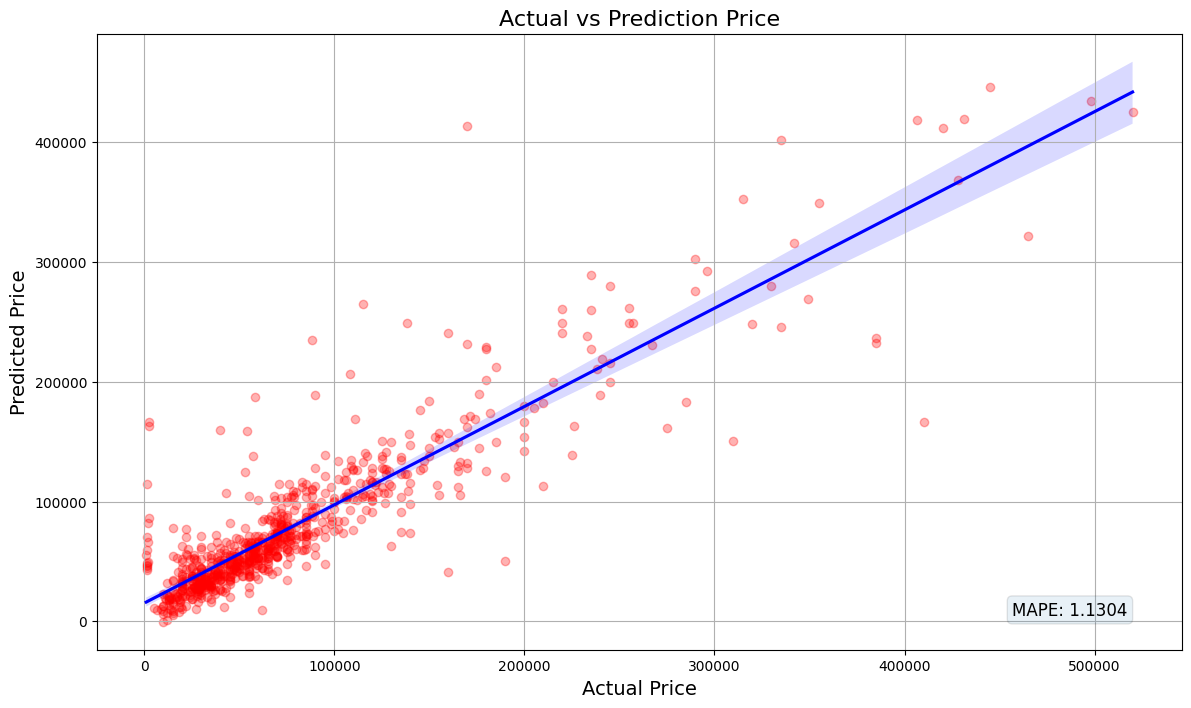

In [20]:
# Scatter plot
plt.figure(figsize=(14, 8))
sns.regplot(x=y_test, y=y_pred, scatter_kws={"color": "red", 'alpha': 0.3}, line_kws={'color': 'blue', 'alpha': 1})

# Tambahkan informasi evaluasi metrik ke plot
plt.text(0.95, 0.05, f'MAPE: {mape_score:.4f}', ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=12, bbox=dict(boxstyle='round', alpha=0.1))

plt.title('Actual vs Prediction Price', fontsize=16)
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.grid(True)

plt.show()

Save Model

In [21]:
import pickle
best_model.fit(X,y)
pickle.dump(best_model, open('best_model_xgboost.sav', 'wb'))


In [22]:
model_loaded = pickle.load(open('best_model_xgboost.sav', 'rb'))
model_loaded

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('One-Hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Options', 'Origin',
                                                   'Gear_Type']),
                                                 ('Binary', BinaryEncoder(),
                                                  ['Type', 'Region', 'Make']),
                                                 ('Robust', RobustScaler(),
                                                  ['Age', 'Engine_Size',
                                                   'Mileage'])])),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_byl...
                              feature_types=None, gamma=0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None, min_child_weight=3,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=500,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=42, ...))])